In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# データ読み込み
train_data = pd.read_csv("titanic/train.csv")
test_data = pd.read_csv("titanic/test.csv")

In [2]:
# 欠損値の処理
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())
train_data['Cabin'] = train_data['Cabin'].fillna('Unknown')
test_data['Cabin'] = test_data['Cabin'].fillna('Unknown')
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])

# 性別を数値に変換
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

train_data["Embarked"] = train_data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
test_data["Embarked"] = test_data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)


In [3]:
# Pythonで決定木の分類器をpruningを使ってモデリングする
from sklearn.model_selection import train_test_split
from sklearn import tree
#特微量
# 既存の特徴量から新しい特徴量を作成
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']
# 特微量の選択に新しい特徴量を含める　　　　　　Embarkedを抜く
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']
X = train_data[features]
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#モデル決定木の訓練
model = tree.DecisionTreeClassifier(random_state=0)
path = model.cost_complexity_pruning_path(X_train, y_train)
eff_alphas, impurities = path.ccp_alphas, path.impurities
print(eff_alphas)
print(impurities)

[0.         0.00015434 0.00016051 0.0001756  0.00025478 0.00026752
 0.00040128 0.00042039 0.00045056 0.00053505 0.00055033 0.00074312
 0.00075406 0.00079022 0.00080257 0.0008424  0.00085607 0.00091873
 0.00093633 0.00095119 0.00100714 0.00103102 0.00107009 0.00107009
 0.00107009 0.00120385 0.00122011 0.00124599 0.00131329 0.00133761
 0.00137583 0.00137583 0.00140641 0.00144462 0.00144462 0.00147138
 0.00155522 0.00158221 0.00162135 0.00166934 0.00167202 0.00178062
 0.00181092 0.00197443 0.0021343  0.00214018 0.00217805 0.00224719
 0.00224719 0.00228286 0.00228286 0.00229294 0.00257714 0.00267523
 0.00282622 0.00287235 0.00296058 0.00298097 0.00301224 0.00302143
 0.0030577  0.0032967  0.00353815 0.00385479 0.00391513 0.0050491
 0.01044429 0.01294038 0.01634019 0.02964259 0.1404436 ]
[0.02447833 0.02463267 0.02479318 0.02496879 0.02522357 0.02575862
 0.02656119 0.02740197 0.0283031  0.02883815 0.02938848 0.03087472
 0.03238284 0.03317306 0.03397563 0.03818763 0.0390437  0.04271862
 0.045

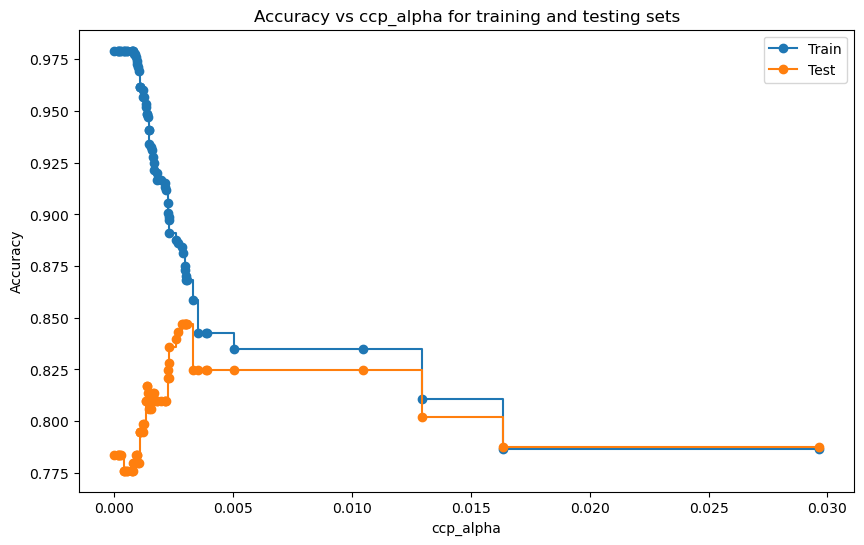

Optimal ccp_alpha: 0.0028262231581108292


In [4]:
# ccp_alphaの値に対するモデルのスコアを保存するリスト
train_scores = []
test_scores = []

# 各ccp_alphaについてモデルを訓練し、スコアを計算
for ccp_alpha in eff_alphas:
    model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# 結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(eff_alphas[:-1], train_scores[:-1], marker='o', label='Train', drawstyle="steps-post")
plt.plot(eff_alphas[:-1], test_scores[:-1], marker='o', label='Test', drawstyle="steps-post")
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ccp_alpha for training and testing sets')
plt.legend()
plt.show()

# 最適なccp_alphaの値を見つける
index_of_max_test_score = np.argmax(test_scores)
optimal_ccp_alpha = eff_alphas[index_of_max_test_score]
print(f"Optimal ccp_alpha: {optimal_ccp_alpha}")
#この場合は0.0028262231581108292？？

TtestResult(statistic=0.8060609887674973, pvalue=0.43368672604448544, df=14)

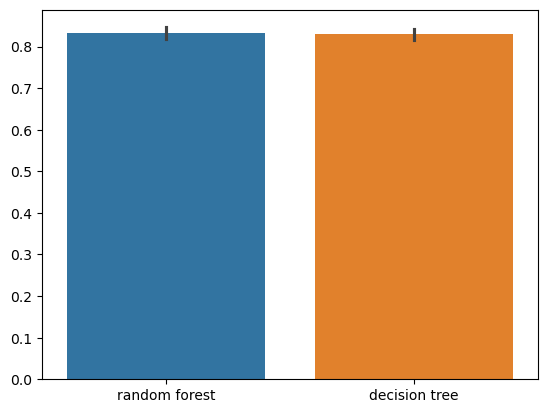

In [9]:
# モデルの構築
from sklearn.ensemble import RandomForestClassifier
# 普通の木も作成してみる
rf_model = RandomForestClassifier(random_state=0, ccp_alpha=0.00282622315811082925)
dt_model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.0028262231581108292)


# 学習と評価
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
rf_scores = cross_val_score(rf_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
dt_scores = cross_val_score(dt_model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)


score_df = pd.DataFrame({"random forest": rf_scores, "decision tree": dt_scores})
sns.barplot(data=score_df)

#t検定
from scipy import stats
stats.ttest_rel(score_df['random forest'], score_df['decision tree'])

<BarContainer object of 5 artists>

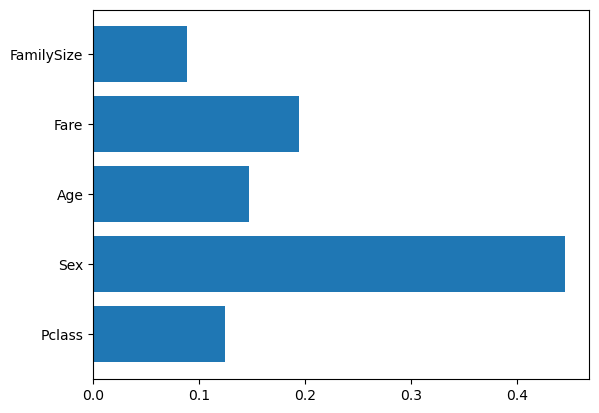

In [10]:
# 特微量の重要度
rf_model.fit(X, y)
plt.barh(X.columns, rf_model.feature_importances_)

In [11]:


# テストデータでの予測準備
X_test = test_data[features]
test_predictions = rf_model.predict(X_test)

# 提出用データフレームの作成
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

# CSVファイルとして保存
submission.to_csv('submission最新.csv', index=False)